# Neural Network Classifier 

We are going to build a PyTorch neural network classifier using scRNAseq data. 

Helpful link:
Interfacing pytorch models with anndata: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html

Possibly helpful about speeding up pytorch modeling: https://sebastianraschka.com/blog/2023/pytorch-faster.html

This program will:

- pull in scRNAseq data from cell_census
- wrangle the data for modelling
- appply the NN

At first, we're just going to pick some data from cell_census. Once we get the basics we will modify to select the exact data we want.


## To Do:

- train, test, holdout and cross validation
- feature engineering to remove useless features

## Done:
- use softmax for final layer
- use Cross entropy loss
- try ADAM optimizer, adjust learning rate
- plot loss curve
- use RELU for each layer
- plot accuracy curve
- add model.trend() and model.eval()
- add batch summarization 



In [2]:
import cell_census
import anndata as ad

from pronto import Ontology

import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Read in the data

For now, we're going to select all 10X 3' V3 leukocyte and lymphocyte human data 

- CL:0000738 = leukocyte
- CL:0000542 = lymphocyte


Using ```development-stage``` for the target value because there are 6 unique values, so we have a multi-class classification problem, which will match our eventual goal. This is a place holder until we get a little further in the development of everything.

In [4]:
census = cell_census.open_soma(census_version="latest")


In [5]:
cl = Ontology.from_obo_library('cl.owl')

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}description' at 0x7f8481182810> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}title' at 0x7f8481182900> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:289: SyntaxWarning: <Element '{http://www.w3.org/2002/07/owl#}versionInfo' at 0x7f8481182ea0> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:113: SyntaxWarning: unknown elem

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.obolibrary.org/obo/}RO_0004050
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.org/dc/terms/}contributor
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://xmlns.com/foaf/0.1/}depicted_by
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: unknown element in `owl:Class`: {http://purl.obolibrary.org/obo/}IAO_0000119
  self._extract_term(class_, curies)
/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/

/Users/josh.fuchs/My Drive/Personal/michigan/venv/lib/python3.8/site-packages/pronto/ontology.py:283: SyntaxWarning: unknown axiom property: 'http://purl.obolibrary.org/obo/UBPROP_0000004'
  cls(self).parse_from(_handle)  # type: ignore


In [5]:
def select_ontology_target_leafs(target_branch):
    '''
    This function identifies are leafs under the target_branch for an open ontology.
    
    Assumes there is an active ontology already open as cl.
    
    Parameters
    ----------
    target_branch : string
        string with ontological ID for branch you want to identify leafs for
        
    Returns
    -------
    leaf_lest : list
        list of ontology IDs for all leafs of target_branch
    
    '''
    root_node = cl[target_branch] 

    leaf_list = []

    for term in root_node.subclasses(distance=None,with_self=False).to_set():
        if term.is_leaf():
            leaf_list.append(term.id)
            
    return leaf_list

In [6]:
def get_data(organism, obs_val_filter, col_names):
    '''
    This function queries data from an active cell census object.
    
    Assumes there is an active census object already open. Assumes you only want to query on cell metadata. 
    Gene metadata querying not currently supported.
    
    Parameters
    ----------
    organism : string
        string containing type of organism you want to query for, i.e. 'Homo sapiens'
        
    obs_val_filter : string
        string containing obs parameters values to filter on
        
    col_names : dictionary
        dictionary of obs or val values to return
        
    Returns
    -------
        AnnData object
    
    '''
    adata = cell_census.get_anndata(
        census=census,
        organism = organism,
        obs_value_filter = obs_val_filter,
        column_names= col_names,
        )
    return adata
    

In [7]:
target_branch = 'CL:0000542' # lymphocyte

leaf_list = select_ontology_target_leafs(target_branch)



In [8]:
leaf_list

['CL:0000918',
 'CL:0009037',
 'CL:0000973',
 'CL:0000935',
 'CL:0000907',
 'CL:0000917',
 'CL:0000948',
 'CL:2000006',
 'CL:0011018',
 'CL:0009081',
 'CL:0000919',
 'CL:0002039',
 'CL:0000903',
 'CL:0001044',
 'CL:0002120',
 'CL:0000895',
 'CL:0002435',
 'CL:0002442',
 'CL:0009050',
 'CL:0000982',
 'CL:0000949',
 'CL:2000054',
 'CL:0009044',
 'CL:0002345',
 'CL:0000934',
 'CL:0009112',
 'CL:0002128',
 'CL:0000910',
 'CL:0002407',
 'CL:0000950',
 'CL:0000925',
 'CL:0000929',
 'CL:0002103',
 'CL:0002123',
 'CL:0001087',
 'CL:0000976',
 'CL:0002338',
 'CL:0000944',
 'CL:0002107',
 'CL:0002106',
 'CL:0000961',
 'CL:4030030',
 'CL:0009033',
 'CL:0002110',
 'CL:0002124',
 'CL:0000977',
 'CL:0001049',
 'CL:0001079',
 'CL:0009059',
 'CL:0000820',
 'CL:0000971',
 'CL:0002446',
 'CL:0009082',
 'CL:0002406',
 'CL:0001075',
 'CL:0009023',
 'CL:0000963',
 'CL:0002415',
 'CL:0001080',
 'CL:0000987',
 'CL:0009068',
 'CL:0002444',
 'CL:0001046',
 'CL:0001073',
 'CL:0000805',
 'CL:0002102',
 'CL:00021

In [37]:
print('''assay == "10x 3\' v3" and cell_type_ontology_term_id in {}'''.format(leaf_list))

assay == "10x 3' v3" and cell_type_ontology_term_id in ['CL:0002413', 'CL:0000956', 'CL:0000951', 'CL:0002106', 'CL:0002434', 'CL:0000966', 'CL:0002430', 'CL:0001042', 'CL:0002416', 'CL:0000958', 'CL:0002061', 'CL:0000937', 'CL:0002445', 'CL:0001046', 'CL:0000982', 'CL:0002345', 'CL:0002679', 'CL:0002089', 'CL:0009114', 'CL:0002103', 'CL:0000932', 'CL:0001077', 'CL:0000960', 'CL:0002429', 'CL:0000978', 'CL:0009064', 'CL:0000977', 'CL:0000903', 'CL:0011024', 'CL:0000935', 'CL:0002442', 'CL:0009044', 'CL:0000545', 'CL:0002052', 'CL:0009032', 'CL:0000933', 'CL:0001044', 'CL:0002439', 'CL:0000900', 'CL:0002050', 'CL:0000984', 'CL:0000934', 'CL:0002444', 'CL:0001050', 'CL:0000963', 'CL:0002406', 'CL:0002427', 'CL:0009046', 'CL:0002127', 'CL:0002446', 'CL:2000006', 'CL:0009062', 'CL:0001081', 'CL:0000927', 'CL:0001048', 'CL:0001202', 'CL:0002120', 'CL:0000926', 'CL:0001049', 'CL:0002423', 'CL:0002042', 'CL:0009112', 'CL:0002218', 'CL:0000920', 'CL:0009051', 'CL:0000805', 'CL:0000965', 'CL:00

In [7]:
obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in ['CL:0001044', 'CL:0000900', 'CL:0000934']'''

#obs_val_filter = '''assay == "10x 3\' v3" and cell_type_ontology_term_id in {}'''.format(leaf_list)


organism = "Homo sapiens"
col_names = {"obs": ["cell_type_ontology_term_id"]}
#col_names = {} # select all

adata = get_data(organism, obs_val_filter, col_names)

In [8]:
display(adata)

AnnData object with n_obs × n_vars = 53605 × 60664
    obs: 'cell_type_ontology_term_id', 'assay'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [9]:
# the data is stored in adata.X
adata.X

<53605x60664 sparse matrix of type '<class 'numpy.float32'>'
	with 93696464 stored elements in Compressed Sparse Row format>

In [10]:
# find the number of features (genes)

adata.X.shape[1]


60664

## Encode and Split the Data into Train/Validate to prepare for modeling

Encode the label values, then split the data into testing and training sets, then put into PyTorch Tensors.

Using self_reported_ethnicity for the labels

In [56]:
def preprocess_data(adata, target_column):
    '''
    This function perfroms preprocessing on ann AnnData object to prepare it for modelling. It will encode the 
    target column and returns x_data and y_data for modelling
    
    
    Parameters
    ----------
    adata : AnnData Object
        existing AnnData object to perform processing on 
        
    target_column : string
        string of target column (from cell metadata) to encode
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    '''
    
    # select the labels. 
    labels = adata.obs
    
    # encode the target column
    lb = LabelEncoder()
    labels['encoded_labels'] = lb.fit_transform(labels[target_column])

    
    x_data = adata.X.copy()
    y_data = labels['encoded_labels']
    
    return(x_data,y_data, labels)

In [55]:
def split_format_data(x_data, y_data, train_size):
    '''
    This function splits x_data and y_data into training and validation sets, then formats the data into
    tensors for modeling with PyTorch
    
    
    Parameters
    ----------
    x_data : scipy matrix
        scipy sparse CSR matrix  
        
    y_data : Series
        Pandas series of encoded target values
        
    train_size: float
        float between 0.0 and 1.0 to select the training fraction of the data set
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    y_data : Series
        Pandas Series of encoded target values
    
    
    X_train : Tensor
        pytorch tensor of training values
    
    X_val : Tensor
        pytorch tensor of validation values
        
    y_train : Tensor
        pytorch tensor of training target values
        
    y_val : Tensor
        pytorch tensor of validation target values
    '''
    
    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,
                                                   train_size = train_size)
    
    
    # convert the data to tensors
    # we'll change the data from CSR (compressed sparse row) format
    # to COO (coordinate) format for better use with pytorch
    # see https://pytorch.org/docs/stable/sparse.html for additional details

    X_train_coo = X_train.tocoo()

    X_train = torch.sparse.LongTensor(torch.LongTensor([X_train_coo.row.tolist(),X_train_coo.col.tolist()]),
                                     torch.LongTensor(X_train_coo.data.astype(np.float32)))

    # y_train is a Series, so it is easier to convert to a tensor
    y_train = torch.tensor(y_train, dtype=torch.long)


    # and the same for the validation set
    X_val_coo = X_val.tocoo()

    X_val = torch.sparse.LongTensor(torch.LongTensor([X_val_coo.row.tolist(),X_val_coo.col.tolist()]),
                                     torch.LongTensor(X_val_coo.data.astype(np.float32)))

    # y_val is a Series, so it is easier to convert to a tensor
    y_val = torch.tensor(y_val, dtype=torch.long)

    
    return(X_train, X_val, y_train, y_val)

In [58]:
target_column = 'cell_type_ontology_term_id'

x_data, y_data, labels = preprocess_data(adata,target_column)

train_size = 0.5

X_train, X_val, y_train, y_val = split_format_data(x_data, y_data, train_size=0.3)


In [9]:
# select the labels. 
# labels = adata.obs

# labels['development_stage'].value_counts()

# lb = LabelEncoder()
# labels['encoded_labels'] = lb.fit_transform(labels['development_stage'])
# labels.head(10)

seventh decade human stage                  23747
sixth decade human stage                    17581
eighth decade human stage                   12497
fifth decade human stage                    10029
fourth decade human stage                    9232
                                            ...  
39-year-old human stage                        34
10th week post-fertilization human stage       27
72-year-old human stage                        18
20th week post-fertilization human stage       13
74-year-old human stage                         7
Name: development_stage, Length: 77, dtype: int64

In [11]:
# find the number of unique labels
labels['encoded_labels'].nunique()

77

In [14]:
y_data.shape

(111060,)

In [15]:
x_data

<111060x60664 sparse matrix of type '<class 'numpy.float32'>'
	with 139596876 stored elements in Compressed Sparse Row format>

In [18]:
X_train

tensor(indices=tensor([[    0,     0,     0,  ..., 77741, 77741, 77741],
                       [   25,    29,    39,  ..., 56325, 57766, 57834]]),
       values=tensor([1, 1, 1,  ..., 1, 4, 1]),
       size=(77742, 60611), nnz=97652679, layout=torch.sparse_coo)

In [19]:
y_train

tensor([72, 24, 73,  ..., 72, 72, 72])

## Build Neural Network Classifier

based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2

another helpful resource: https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model

In [14]:
test_size = torch.unique(y_train).size(dim=0)

test_size

3

In [46]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of hidden layers
hidden_layers = 10

# number of classes (unique of y)
output_dim = torch.unique(y_train).size(dim=0) #labels['encoded_labels'].nunique()

In [47]:
print(input_dim,hidden_layers,output_dim)

60611 10 3


In [48]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layers)
        self.linear2 = nn.Linear(hidden_layers,output_dim)
        self.bn = nn.BatchNorm1d(10)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.softmax(x,dim=1)
        return x

## Train the Model

In [27]:
# initialize network

clf = Network()

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

epochs = 100
accuracy_vals = []
loss_vals = []

# set the model to training
clf.train()

for epoch in range(epochs):
    running_loss = 0.0

    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
  
    # forward propagation
    outputs = clf(X_train.float())
    loss = criterion(outputs, y_train)
    
    # backward propagation
    loss.backward()
    
    # optimize
    optimizer.step()
    running_loss += loss.item()
    
    # save accuracy
    _, epoch_pred = outputs.max(dim=1)
    correct = (epoch_pred == y_train).sum().item()
    accuracy_vals.append(correct / len(y_train) * 100.)

    # save loss
    loss_vals.append(loss.item())
    
    # display statistics
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.8f} accuracy: {accuracy_vals[-1]:.4f}')


[1] loss: 1.61728120 accuracy: 13.2490
[10] loss: 1.52344155 accuracy: 55.4209
[20] loss: 1.46894157 accuracy: 70.0381
[30] loss: 1.43148994 accuracy: 73.6231
[40] loss: 1.39798081 accuracy: 78.6283
[50] loss: 1.36467600 accuracy: 82.3000
[60] loss: 1.33435214 accuracy: 86.1967
[70] loss: 1.30199873 accuracy: 90.2148
[80] loss: 1.27349961 accuracy: 94.0423
[90] loss: 1.24101067 accuracy: 95.8261
[100] loss: 1.21379137 accuracy: 96.7960


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_46767/353249328.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


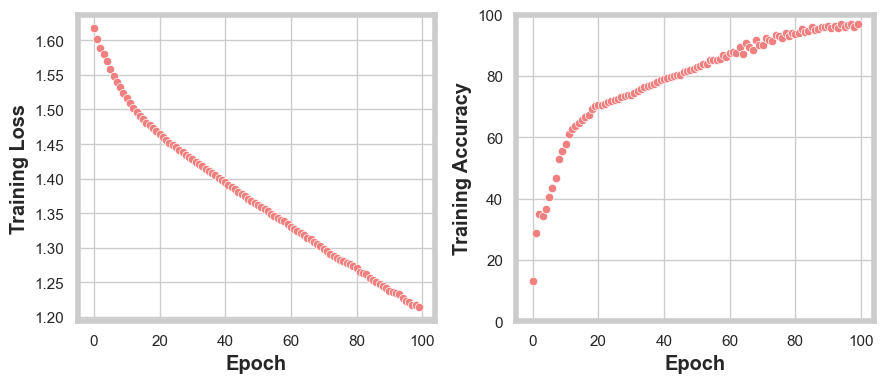

In [28]:
# plot the loss and accuracy curves

fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.scatterplot(x=range(epochs),y=loss_vals, ax = ax[0],color='lightcoral')
sns.scatterplot(x=range(epochs),y=accuracy_vals, ax = ax[1],color='lightcoral')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')
ax[1].set_ylim((0,100))
fig.show()

## Validate the model

Most of this work is based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2



In [29]:
clf.eval()

outputs_val = clf(X_val.float())
__, predicted = torch.max(outputs_val,1)
print(predicted)

tensor([4, 2, 4,  ..., 0, 0, 3])


In [30]:
torch.unique(predicted, return_counts=True)

(tensor([0, 1, 2, 3, 4]), tensor([ 7259,  6160, 13600, 12697, 12257]))

In [31]:
clf.eval()

correct, total = 0, 0

with torch.no_grad():
    # calculate output by running through the network
    outputs = clf(X_val.float())
    
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    
    # update results
    total += y_val.size(0)
    correct += (predicted == y_val).sum().item()
    
print(f'Accuracy of the network on the test data: {100 * correct // total:.2f} %')

Accuracy of the network on the test data: 88.00 %


## Train and Validate Together

Let's write a function to to the training and validation all at once, so we can compare loss/accuracy curves.

helpful for hyperparameter tuning: https://machinelearningmastery.com/training-and-validation-data-in-pytorch/

In [51]:
def train_and_validate(num_epochs):
    '''
    Performs training and validation simultaneously to allow visualization of model performance 
    per epoch. 
    
    Parameters
    ----------
    num_epochs : int
        integer specify the number of epochs
        
    Returns
    -------
    accuracy_train_hist : list
        list containing accuracy for the training set per epoch
        
    loss_train_hist: list
        list containing loss values for the training set per epoch
        
    accuracy_val_hist : list 
        list containing accuracy for the validation set per epoch
        
    loss_val_hist : list
        list containing loss values for the validation set per epoch
    '''
    # initialize variables for saving values
    accuracy_train_hist = []
    loss_train_hist = []
    accuracy_val_hist = []
    loss_val_hist = []
    best_accuracy = - np.inf
    best_weights = None

    # initialize network
    clf = Network()
    # define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        
        # TRAINING
        #print('Begin Training...')
        clf.train()
        running_train_loss = 0.0
        #running_accuracy = 0.0
        #running_vallidation_loss = 0.0
        #total = 0

        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()

        # forward propagation
        outputs_train = clf(X_train.float())
        loss_train = criterion(outputs_train, y_train)

        # backward propagation
        loss_train.backward()

        # optimize
        optimizer.step()
        running_train_loss += loss_train.item()

        # save accuracy
        _, train_pred = outputs_train.max(dim=1)
        correct_train = (train_pred == y_train).sum().item()
        accuracy_train_hist.append(correct_train / len(y_train) * 100.)

        # save loss
        loss_train_hist.append(loss_train.item())
        
        with torch.no_grad():
            clf.eval()
            # calculate output by running through the network
            outputs_val = clf(X_val.float())

            # get the predictions
            __, predicted_val = outputs_val.max(dim=1)

            # calculate loss
            loss_val = criterion(outputs_val, y_val)

            # save accuracy
            correct_val = (predicted_val == y_val).sum().item()
            accuracy_val_hist.append(correct_val / len(y_val) * 100.)

            # save loss
            loss_val_hist.append(loss_val.item())
            
            # check if best model
            if accuracy_val_hist[-1] > best_accuracy:
                best_acc = accuracy_val_hist[-1]
                best_weights = copy.deepcopy(clf.state_dict())
                best_output = copy.deepcopy(outputs_val)
            
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'[{epoch + 1}] Training Accuracy: {accuracy_train_hist[-1]:.3f} Validation Accuracy: {accuracy_val_hist[-1]:.3f}')

    print(f'Best Accuracy: {best_acc:.3f}')
    #print('Best Weights: ')
    #print(best_weights)
    return(accuracy_train_hist, loss_train_hist, accuracy_val_hist, loss_val_hist, best_output)

        

In [52]:
# set the number of epochs and run the model

num_epochs = 11

accuracy_train_hist, loss_train_hist, accuracy_val_hist, loss_val_hist, best_output = train_and_validate(num_epochs)

[1] Training Accuracy: 38.549 Validation Accuracy: 51.762
[10] Training Accuracy: 83.994 Validation Accuracy: 87.637
Best Accuracy: 87.874


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_29538/488324102.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


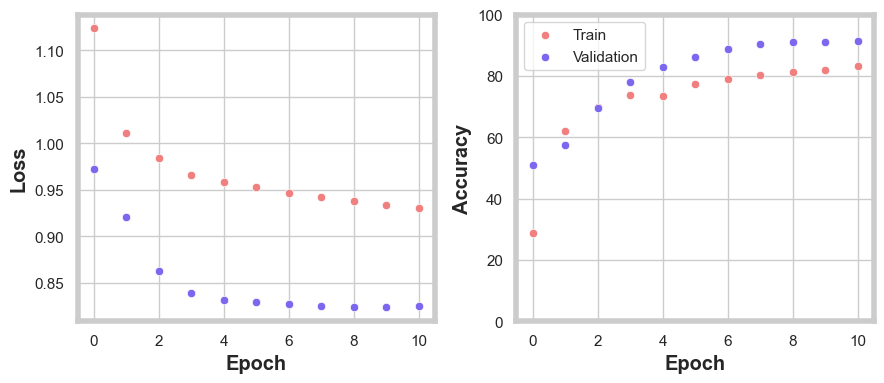

In [50]:


fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.scatterplot(x=range(num_epochs),y=loss_train_hist, ax = ax[0],color='lightcoral')
sns.scatterplot(x=range(num_epochs),y=accuracy_train_hist, ax = ax[1],color='lightcoral',label='Train')

sns.scatterplot(x=range(num_epochs),y=loss_val_hist, ax = ax[0],color='mediumslateblue')
sns.scatterplot(x=range(num_epochs),y=accuracy_val_hist, ax = ax[1],color='mediumslateblue',label='Validation')


ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim((0,100))
fig.show()

## Perform Heirarchical Classification

1) Inverse transform classifications into ontology IDs
2) Match IDs with probabilities
3) Identify parents
4) Sum probablities

best_output is a tensor of probabilities by class

In [53]:
best_output

tensor([[8.7304e-01, 1.5491e-02, 1.1146e-01],
        [8.6870e-01, 1.7381e-02, 1.1391e-01],
        [2.8564e-01, 3.7736e-01, 3.3700e-01],
        ...,
        [5.7835e-03, 7.1327e-04, 9.9350e-01],
        [9.4726e-01, 5.9998e-03, 4.6744e-02],
        [9.0775e-01, 9.6983e-03, 8.2556e-02]])

In [76]:
# match encoded labels to ontology IDs

number_of_labels = labels['encoded_labels'].unique().size

label_dict = {}

for x in range(number_of_labels):
    label_dict[x] = labels[labels['encoded_labels'] == x][target_column].unique().tolist()[0]

label_dict

{0: 'CL:0000900', 1: 'CL:0000934', 2: 'CL:0001044'}

In [44]:
def find_parent(subclass, distance=1):
    '''
    Finds parent(s) of input subclass for current ontology, which must be loaded as cl. Parents will be 
    found within input distance of subclass. Immediate parents correspond with distance = 1. 
    
    Parameters
    ----------
    subclass : str
        string with full name of subclass you want to identify the parents of
        
    distance (optional): int
        distance from subclass you want to find parents of
        default = 1
        
    Returns
    -------
    parents : list
        list of parents for input subclass
    '''
    root_node = cl[subclass]
    parents = []
    for term in root_node.superclasses(distance=distance,with_self=False).to_set():
        parents.append(term.id)
    return parents

In [45]:
for leaf in label_dict.values():
    print('Parent of ', leaf, 'is:')
    leaf_parent = find_parent(leaf)
    print(leaf_parent)

NameError: name 'label_dict' is not defined

In [46]:
find_parent('CL:0001061')

['CL:0000000']

In [11]:
def add_probability_to_parent_nodes(ids,prob,probability_dict):
    '''
    Add probability of ids node to each parent node in the ontology.
    
    A current ontology must be loaded as CL.
    
    If multiple parents loop back to the same super-parent, probability will be summed twice. 

    Parameters
    ----------
    ids : str
        string with full name of subclass you want to sum the probabilities for
        
    prob: float
        distance from subclass you want to find parents of
        default = 1
        
    Returns
    -------
    parents : list
        list of parents for input subclass
    '''

    # get parent ids
    parents_of_id = find_parent(ids)

    # if parent ID = CL:0000000 (CELL), then done
    # if not, then add probability to each parent
    # for each parent, check if ID has a parent
    if 'CL:0000000' in parents_of_id:
        # we're at the final node
        pass
    else:
        for parent in parents_of_id:
            if parent in probability_dict:
                probability_dict[parent] += prob
            else:
                probability_dict[parent] = prob
            probability_dict = add_probability_to_parent_nodes(parent,prob,probability_dict)
    return(probability_dict)



In [12]:
# get one ID from best_output tensor

ids = 'CL:0000934'
prob = 0.3

# set up final probability dictionary
probability_dict = {}

new_dict = add_probability_to_parent_nodes(ids,prob,probability_dict)




In [13]:
new_dict

{'CL:0000624': 0.3,
 'CL:0000791': 0.3,
 'CL:0000789': 0.3,
 'CARO:0000006': 0.6,
 'CARO:0000000': 1.2,
 'CARO:0030000': 1.2,
 'BFO:0000004': 1.8,
 'BFO:0000002': 1.8,
 'PR:000050567': 0.6,
 'BFO:0000040': 0.6,
 'CL:0000084': 0.6,
 'CL:0000542': 0.6,
 'CL:0000842': 0.6,
 'CL:0000738': 0.6,
 'CL:0000219': 0.6,
 'CL:0000003': 2.9999999999999996,
 'CL:0002242': 1.2,
 'CL:0000988': 0.6,
 'CL:0002371': 0.6,
 'CL:0000548': 0.6,
 'CL:0000255': 0.6,
 'CL:0000226': 0.6,
 'CL:0002419': 0.3}

In [43]:
find_parent('CL:0002242')

['CL:0000003']

In [47]:
ids = 'CL:0000900'
prob = 0.1

# set up final probability dictionary
#probability_dict = {}

second_dict = add_probability_to_parent_nodes(ids,prob,new_dict)
second_dict

{'CL:0000624': 0.3,
 'CL:0000791': 0.4,
 'CL:0000789': 0.4,
 'CARO:0000006': 0.8999999999999999,
 'CARO:0000000': 1.8000000000000005,
 'CARO:0030000': 1.8000000000000005,
 'BFO:0000004': 2.7000000000000006,
 'BFO:0000002': 2.7000000000000006,
 'PR:000050567': 0.8999999999999999,
 'BFO:0000040': 0.8999999999999999,
 'CL:0000084': 0.8999999999999999,
 'CL:0000542': 0.8999999999999999,
 'CL:0000842': 0.8999999999999999,
 'CL:0000738': 0.8999999999999999,
 'CL:0000219': 0.8999999999999999,
 'CL:0000003': 4.499999999999998,
 'CL:0002242': 1.8000000000000005,
 'CL:0000988': 0.8999999999999999,
 'CL:0002371': 0.8999999999999999,
 'CL:0000548': 0.8999999999999999,
 'CL:0000255': 0.8999999999999999,
 'CL:0000226': 0.8999999999999999,
 'CL:0002419': 0.5,
 'CL:0000898': 0.1,
 'CL:0000625': 0.1}